In [1]:
# import libraries
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
import healpy
from icecube import icetray, dataclasses, dataio, recclasses

In [2]:
# file provided by Jaun-Carlos (plus printing the keys for easy view)
# Load in the data file (contains SYBILL 2.3d data)
d = np.load("/data/user/juancarlos/notebooks/dst_20904_v3.npz")
print(list(d.keys()))

['nchannel', 'llhZen', 'llhAz', 'zenith', 'azimuth', 'mc_energy', 'type', 'isgoodllh', 'ndir', 'ldir', 'rlogl', 'atmosphere', 'TriggID_1006', 'cogx', 'cogy', 'cogz', 'logMuE', 'energy', 'GaisserH3a', 'Hoerandel', 'GlobalFitGST', 'GlobalSplineFit5Comp', 'GaisserH4a', 'reco_energy']


In [3]:
# set up quality cut for professional data
qual_cut = (d['zenith'] > 0.002) * (d['zenith'] < (np.pi - 0.002)) * (d['nchannel'] >= 10) * (d['rlogl'] < 25)
# set up bin cut
bin_cut = np.logical_and(d['reco_energy'] > 4, d['reco_energy'] < 8)

In [4]:
# weighted quantiles function used to calculate the median rigidity bin
def weighted_quantiles(values, weights, quantiles=0.5):
    if len(values) == 0:
        return 0
    i = np.argsort(values)
    c = np.cumsum(weights[i])
    return values[i[np.searchsorted(c, np.array(quantiles) * c[-1])]]

In [5]:
# functions to calculate Z value per event, save to array, then take the log10 of the array.
#define a function to go from PDG code to Z
def _get_charge(ptype):
    if ptype<1000020040:
        return 1
    else:
        remainder = int(ptype)%1000000000
        remainder -= remainder%1000
        
        return remainder/10000
    
#turn it into a vectorized function (for speed)
get_charge = np.vectorize(_get_charge)

#example of usage
zarray = get_charge(d['type'])

# create log10(z) array for later cells
lza = np.log10(zarray)

In [6]:
# set up compositional cuts to separate data by composition
pcut = d['type'] == 2212
Hecut = d['type'] == 1.00002004e+09
Ncut = d['type'] == 1.000070140e+09
Alcut = d['type'] == 1.00013027e+09
Fecut =  d['type'] == 1.00026056e+09

In [7]:
# set up dictionaries for later cells
# set up compositional cuts to separate data by composition
CCUT={
    'proton': d['type'] == 2212,
    'helium': d['type'] == 1.00002004e+09,
    'nitrogen': d['type'] == 1.000070140e+09,
    'aluminum': d['type'] == 1.00013027e+09,
    'iron': d['type'] == 1.00026056e+09
}
# Bins sets up energy bin tier cuts
BINS={
'4.125': np.logical_and(d['reco_energy'] > 4, d['reco_energy'] < 4.25),
'4.375': np.logical_and(d['reco_energy'] > 4.25, d['reco_energy'] < 4.5),
'4.625': np.logical_and(d['reco_energy'] > 4.5, d['reco_energy'] < 4.75),
'4.875': np.logical_and(d['reco_energy'] > 4.75, d['reco_energy'] < 5),
'5.125': np.logical_and(d['reco_energy'] > 5, d['reco_energy'] < 5.25),
'5.375': np.logical_and(d['reco_energy'] > 5.25, d['reco_energy'] < 5.5),
'5.75': np.logical_and(d['reco_energy'] > 5.5, d['reco_energy'] < 6),
'6.25': np.logical_and(d['reco_energy'] > 6, d['reco_energy'] < 6.5), 
'7.25': d['reco_energy'] > 6.5
}
# Binc sets up energy bin color scheme to differentiate in later histograms
BINC={
'4.125': 'red',
'4.375': 'orange',
'4.625': 'darkgreen',
'4.875': 'cyan',
'5.125': 'blue',
'5.375': 'purple',
'5.75': 'brown',
'6.25': 'black',
'7.25': 'magenta'
}
# Compc sets up a dictionary for color by composition
COMPC={
    'proton': 'red',
    'Helium': 'orange',
    'Nitrogen': 'darkgreen',
    'Aluminum': 'blue',
    'Iron': 'purple'
}
# Binl sets up energy bin label scheme to differentiate in later histograms
BINL={
'4.125': '4.13',
'4.375': '4.38',
'4.625': '4.63',
'4.875': '4.88',
'5.125': '5.13',
'5.375': '5.38',
'5.75': '5.75',
'6.25': '6.35',
'7.25': '7.25'
}

IC_COMPS = {
    'proton': pcut,
    'helium': Hecut,
    'nitrogen': Ncut,
    'aluminum': Alcut,
    'iron': Fecut
}

Z = {
    'proton': 1,
    'helium': 2,
    'nitrogen': 7,
    'oxygen': 8,
    'aluminum': 13,
    'iron': 26
}

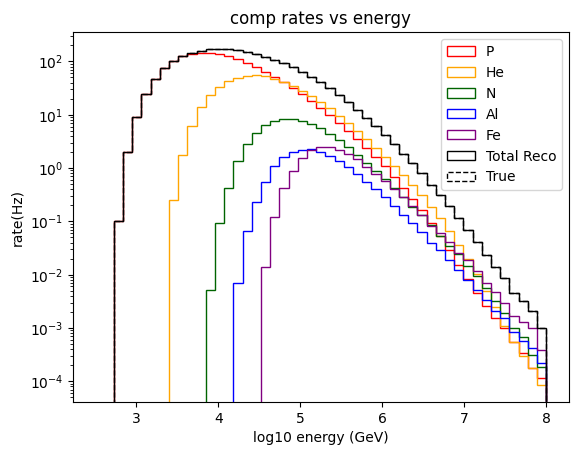

In [8]:
# Cell to initially visualize both the reconstructed compositional energy and the true energy
bins=np.linspace(2.5, 8, 50)

(pwtH, bins, patches1) = plt.hist(np.log10(d['mc_energy'][pcut]), bins = bins, log = True, weights=d['GaisserH4a'][pcut], color = 'red',histtype = 'step', label ='P')
(hwtH, bins, patches1) = plt.hist(np.log10(d['mc_energy'][Hecut]), bins = bins, log = True, weights=d['GaisserH4a'][Hecut],color = 'orange',histtype = 'step', label = 'He') 
(nwtH, bins, patches1) = plt.hist(np.log10(d['mc_energy'][Ncut]), bins = bins, log = True, weights=d['GaisserH4a'][Ncut], color='darkgreen',histtype = 'step', label = 'N')
(awtH, bins, patches1) = plt.hist(np.log10(d['mc_energy'][Alcut]), bins = bins, log = True, weights=d['GaisserH4a'][Alcut], color='blue',histtype = 'step', label = 'Al')
(iwtH, bins, patches1) = plt.hist(np.log10(d['mc_energy'][Fecut]), bins = bins, log=True, weights=d['GaisserH4a'][Fecut], color='purple', histtype='step',label='Fe')
(rwtH, bins, patches1) = plt.hist(np.log10(d['mc_energy']), bins = bins, log = True, weights = d['GaisserH4a'], color = 'black', histtype = 'step', label = 'Total Reco')
(true, bins, patches1) = plt.hist(np.log10(d['energy']), bins = bins, log=True, weights = d['GaisserH4a'], color = 'black', histtype = 'step', label = 'True', linestyle = '--')
totH = pwtH + hwtH + nwtH + awtH + iwtH
plt.xlabel('log10 energy (GeV)')
plt.ylabel('rate(Hz)')
plt.title('comp rates vs energy')
plt.legend()
plt.show()

In [9]:
# Cell to define the median energy bins
def getEbins():
    return [4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 6, 6.5]
ebins = getEbins() + [8]
emids = (np.asarray(ebins)[1:] + np.asarray(ebins)[:-1])/2
print(emids)

[4.125 4.375 4.625 4.875 5.125 5.375 5.75  6.25  7.25 ]


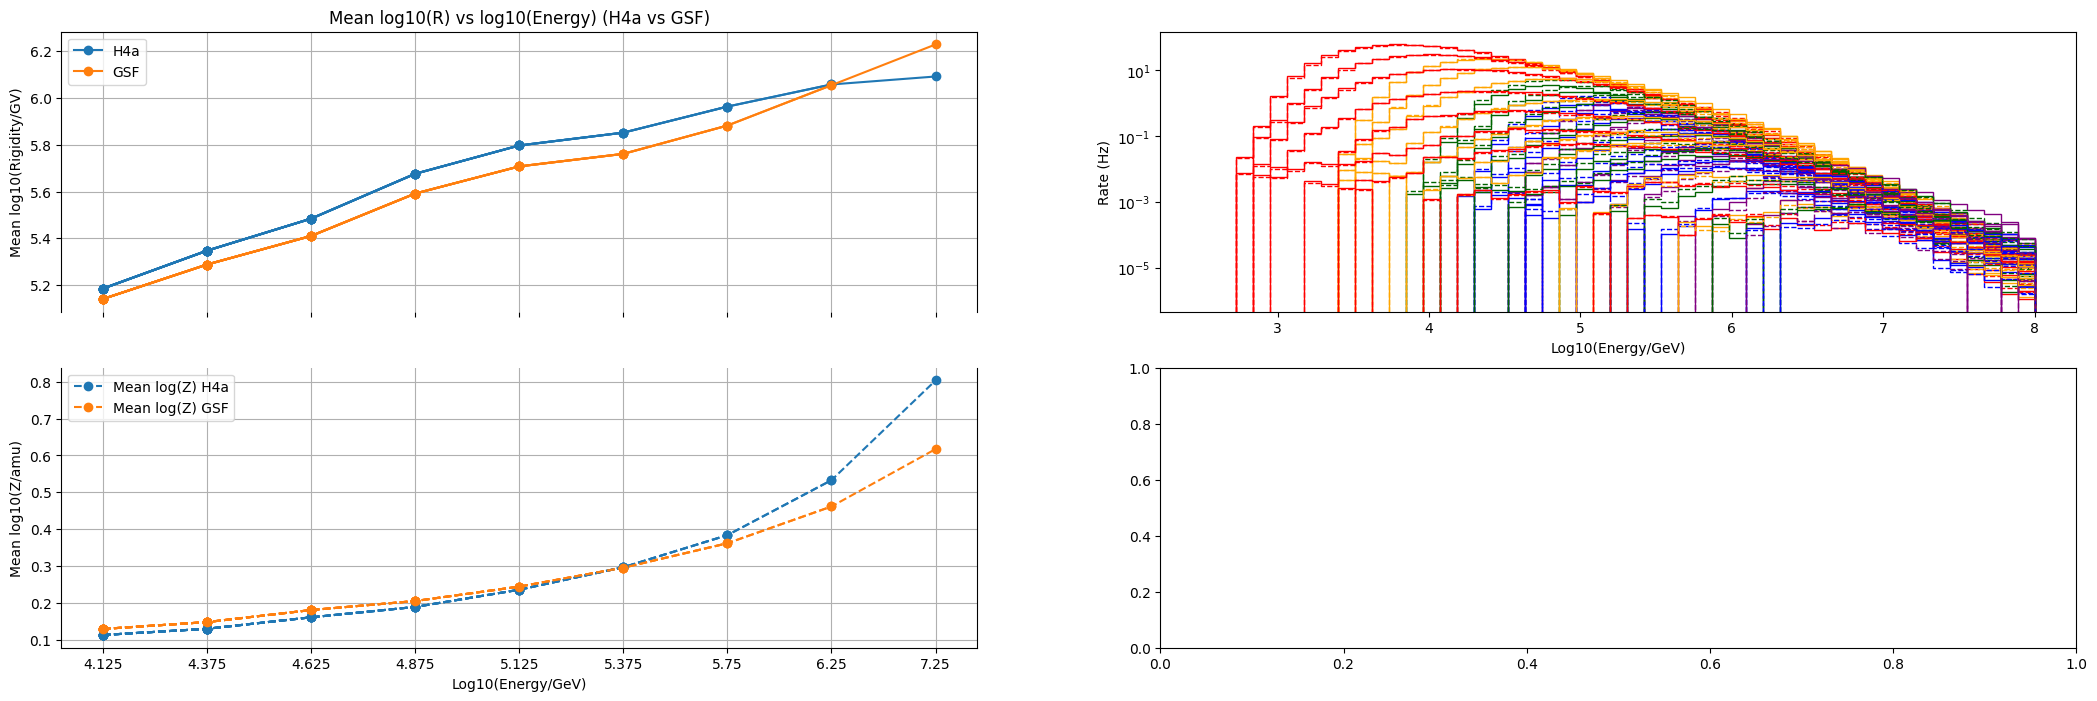

In [10]:
# Mega cell that produces mean rigidity calculations and graphs.
bins=np.linspace(2.5, 8, 50)
fig, axs = plt.subplots(figsize = (26, 8), ncols=2, nrows=2)

rigidHArr = []
rigidGArr = []
meanZHArr=[]
meanZGArr=[]

for tier in BINS:
    totH = 0
    totG = 0

    meco = np.log10(d['mc_energy'])
    
    # Plot the binned composition for GaisserH4a weight
    [pH, binph, p1] = axs[0,1].hist(meco[np.logical_and(BINS[tier],pcut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],pcut)], color = 'red',histtype = 'step', label ='P', density=False)
    [HeH, binhh, p2] = axs[0,1].hist(meco[np.logical_and(BINS[tier],Hecut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Hecut)], color = 'orange',histtype = 'step', label ='He', density=False)
    [NH, binnh, p3] = axs[0,1].hist(meco[np.logical_and(BINS[tier],Ncut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Ncut)], color = 'darkgreen',histtype = 'step', label ='N', density=False)
    [AlH, binah, p4] = axs[0,1].hist(meco[np.logical_and(BINS[tier],Alcut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Alcut)], color = 'blue',histtype = 'step', label ='Al', density=False)
    [FeH, binfh, p5] = axs[0,1].hist(meco[np.logical_and(BINS[tier],Fecut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Fecut)], color = 'purple',histtype = 'step', label ='Fe', density=False)
    totH = pH + HeH + NH + AlH + FeH
    
    # Plot the binned composition for GlobalSplineFit5Comp weight
    [pG, binpg, p6] = axs[0,1].hist(meco[np.logical_and(BINS[tier],pcut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],pcut)], color = 'red',histtype = 'step', linestyle='--', label ='P', density=False)
    [HeG, binhg, p7] = axs[0,1].hist(meco[np.logical_and(BINS[tier],Hecut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Hecut)], color = 'orange',histtype = 'step', linestyle='--', label ='He', density=False)
    [NG, binng, p8] = axs[0,1].hist(meco[np.logical_and(BINS[tier],Ncut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Ncut)], color = 'darkgreen',histtype = 'step', linestyle='--', label ='N', density=False)
    [AlG, binag, p9] = axs[0,1].hist(meco[np.logical_and(BINS[tier],Alcut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Alcut)], color = 'blue',histtype = 'step', linestyle='--', label ='Al', density=False)
    [FeG, binfg, p10] = axs[0,1].hist(meco[np.logical_and(BINS[tier],Fecut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Fecut)], color = 'purple',histtype = 'step', linestyle='--', label ='Fe', density=False)
    totG = pG + HeG + NG + AlG + FeG
    
    # Calculate the discrete binned fractional composition for the GaisserH4a weight
    pfracH = np.nanmean(pH) / np.nanmean(totH)
    HefracH = np.nanmean(HeH) / np.nanmean(totH)
    NfracH = np.nanmean(NH) / np.nanmean(totH)
    AlfracH = np.nanmean(AlH) / np.nanmean(totH)
    FefracH = np.nanmean(FeH) / np.nanmean(totH)

    # Calculate the discrete binned fractional composition for the GlobalSplineFit5Comp weight
    pfracG = np.nanmean(pG) / np.nanmean(totG)
    HefracG = np.nanmean(HeG) / np.nanmean(totG)
    NfracG = np.nanmean(NG) / np.nanmean(totG)
    AlfracG = np.nanmean(AlG) / np.nanmean(totG)
    FefracG = np.nanmean(FeG) / np.nanmean(totG)
    
    # Calculate the mean base 10 log charge and atomic mass for GaisserH4a weight
    meanAH = ((pfracH * np.log10(1)) + (HefracH*np.log10(4)) + (NfracH*np.log10(14)) + (AlfracH*np.log10(27)) + (FefracH*np.log10(56)))
    meanZH = ((pfracH*np.log10(1)) + (HefracH*np.log10(2)) + (NfracH*np.log10(7)) + (AlfracH*np.log10(13)) + (FefracH*np.log10(26)))

    # Calculate the mean base 10 log charge and atomic mass for GlobalSplineFit5Comp weight
    meanAG= ((pfracG * np.log10(1)) + (HefracG*np.log10(4)) + (NfracG*np.log10(14)) + (AlfracG*np.log10(27)) + (FefracG*np.log10(56)))
    meanZG = ((pfracG*np.log10(1)) + (HefracG*np.log10(2)) + (NfracG*np.log10(7)) + (AlfracG*np.log10(13)) + (FefracG*np.log10(26)))

    # Calculate the discrete weighted rigidities (for rgidity line graph)
    rigidH = np.average(meco[np.logical_and(BINS[tier], qual_cut)], weights=d['GaisserH4a'][np.logical_and(BINS[tier], qual_cut)]) - (meanZH / 1)
    rigidG = np.average(meco[np.logical_and(BINS[tier], qual_cut)], weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier], qual_cut)]) - (meanZG / 1)
    
    # Print values
    #print('**Energy bin: ' + tier + '**')
    #print('--------------------')
    #print('Proton (H4a): ' + str(round(pfracH, 3)))
    #print('Proton (GSF): ' + str(round(pfracG, 3)))
    #print('|--------------------|')
    #print('Helium (H4a): ' + str(round(HefracH, 3)))
    #print('Helium (GSF): ' + str(round(HefracG, 3)))
    #print('|--------------------|')
    #print('Nitrogen (H4a): ' + str(round(NfracH, 3)))
    #print('Nitrogen (GSF): ' + str(round(NfracG, 3)))
    #print('|--------------------|')
    #print('Aluminum (H4a): ' + str(round(AlfracH, 3)))
    #print('Aluminum (GSF): ' + str(round(AlfracG, 3)))
    #print('|--------------------|')
    #print('Iron (H4a): ' + str(round(FefracH, 3)))
    #print('Iron (GSF): ' + str(round(FefracG, 3)))
    #print('--------------------')
    #print('Mean Log10(Z) (H4a): ' + str(round(meanZH, 3)))
    #print('Mean Log10(Z) (GSF): ' + str(round(meanZG, 3)))
    #print('|--------------------|')
    #print('Mean Log10(A) (H4a): ' + str(round(meanAH, 3)))
    #print('Mean Log10(A) (GSF): ' + str(round(meanAG, 3)))
    #print('|--------------------|')
    #print('Mean log10(R) (H4a): ' + str(round(rigidH, 3)))
    #print('Mean log10(R) (GSF): ' + str(round(rigidG, 3)))
    #print()

    rigidHArr.append(rigidH)
    rigidGArr.append(rigidG)
    meanZHArr.append(meanZH)
    meanZGArr.append(meanZG)

    # Plot discrete rigidity (for rigidity line chart)
    axs[0,0].plot(rigidHArr, label='H4a' if tier == '4.125' else '', color='C0', marker='o')
    axs[0,0].plot(rigidGArr, label='GSF' if tier == '4.125' else '', color='C1', marker='o')
    axs[1,0].plot(meanZHArr, label='Mean log(Z) H4a' if tier == '4.125' else '', color='C0', linestyle='--', marker='o')
    axs[1,0].plot(meanZGArr, label='Mean log(Z) GSF' if tier == '4.125' else '', color='C1', linestyle='--', marker='o')
    
# Show plots
axs[0,1].set_xlabel('Log10(Energy/GeV)')
axs[0,1].set_ylabel('Rate (Hz)')
#axs[0,1].set_title('Binned Composition Rates vs. Energy')
axs[0,0].set_title('Mean log10(R) vs log10(Energy) (H4a vs GSF)')
axs[1,0].set_xlabel('Log10(Energy/GeV)')
axs[0,0].set_ylabel('Mean log10(Rigidity/GV)')
axs[1,0].set_ylabel('Mean log10(Z/amu)')
axs[1,0].set_xticks(np.arange(0,9,1))
axs[1,0].set_xticklabels(['4.125','4.375','4.625','4.875','5.125','5.375','5.75','6.25','7.25'])
axs[0,0].set_xticklabels('')
axs[0,0].spines['bottom'].set_visible(False)
axs[1,0].spines['top'].set_visible(False)
axs[0,0].grid()
axs[1,0].grid()
axs[0,0].legend()
axs[1,0].legend()
plt.show()

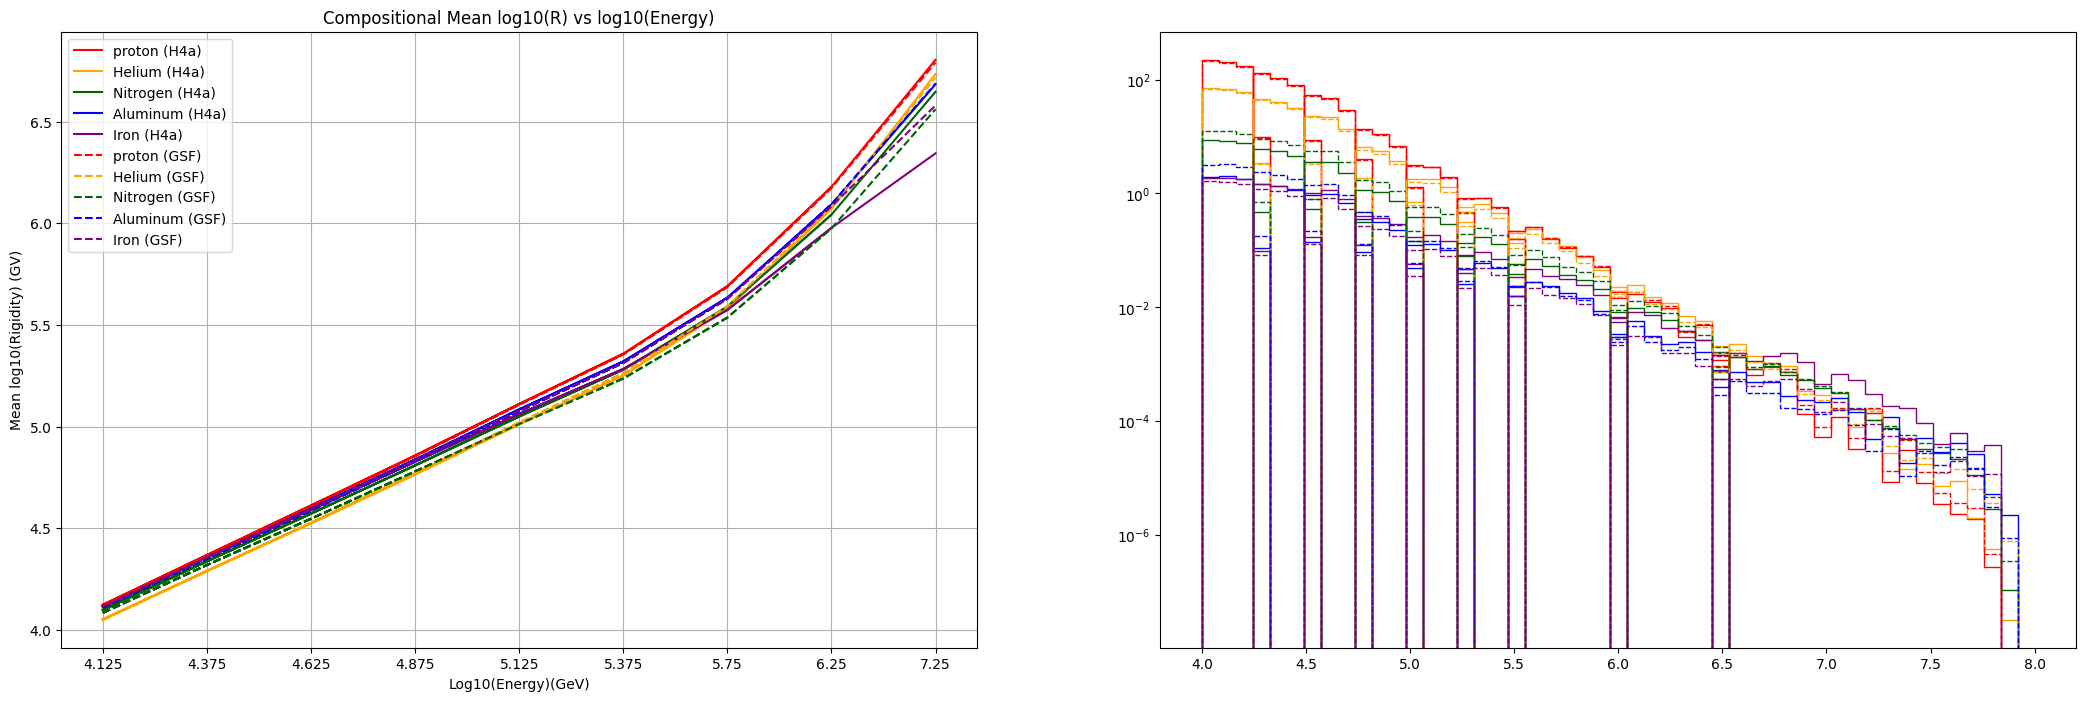

In [11]:
# Cell that produces mean compositional rigidity per composition (might delete later)(using as basis for compositional rigidity)
bins=np.linspace(4, 8, 50)
ncols=2
fig, axs = plt.subplots(figsize = (13 * ncols, 8), ncols=ncols)
# dictionaries to save elemental rigidity for each compositional interaction model (H4a, GSF)
RigiDH = {
    'pRH': [],
    'HeRH': [],
    'NRH': [],
    'AlRH': [],
    'FeRH': []
}

RigiDG = {
    'pRG':  [],
    'HeRG': [],
    'NRG': [],
    'AlRG': [],
    'FeRG': []
}
# another color dictionary for composition based color scheme
COLORS={
    'pRH': 'red',
    'pRG': 'red',
    'HeRH': 'orange',
    'HeRG': 'orange',
    'NRH': 'darkgreen',
    'NRG': 'darkgreen',
    'AlRH': 'blue',
    'AlRG': 'blue',
    'FeRH': 'purple',
    'FeRG': 'purple'
}
# composition based labeling scheme
LABELS={
    'pRH': 'proton (H4a)',
    'pRG': 'proton (GSF)',
    'HeRH': 'Helium (H4a)',
    'HeRG': 'Helium (GSF)',
    'NRH': 'Nitrogen (H4a)',
    'NRG': 'Nitrogen (GSF)',
    'AlRH': 'Aluminum (H4a)',
    'AlRG': 'Aluminum (GSF)',
    'FeRH': 'Iron (H4a)',
    'FeRG': 'Iron (GSF)'
}

# For loop to create and calculate compositional histograms and mean compositional rigidity
for tier in BINS:
    totH = 0
    totG = 0

    # Plot the binned composition for GaisserH4a weight
    [pH, bins, patches1] = axs[1].hist(d['reco_energy'][np.logical_and(BINS[tier],pcut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],pcut)], color = 'red',histtype = 'step', label ='P', density=False)
    [HeH, bins, patches1] = axs[1].hist(d['reco_energy'][np.logical_and(BINS[tier],Hecut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Hecut)], color = 'orange',histtype = 'step', label ='He', density=False)
    [NH, bins, patches1] = axs[1].hist(d['reco_energy'][np.logical_and(BINS[tier],Ncut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Ncut)], color = 'darkgreen',histtype = 'step', label ='N', density=False)
    [AlH, bins, patches1] = axs[1].hist(d['reco_energy'][np.logical_and(BINS[tier],Alcut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Alcut)], color = 'blue',histtype = 'step', label ='Al', density=False)
    [FeH, bins, patches1] = axs[1].hist(d['reco_energy'][np.logical_and(BINS[tier],Fecut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Fecut)], color = 'purple',histtype = 'step', label ='Fe', density=False)
    totH = pH + HeH + NH + AlH + FeH
    
    # Plot the binned composition for GlobalSplineFit5Comp weight
    [pG, bins, patches1] = axs[1].hist(d['reco_energy'][np.logical_and(BINS[tier],pcut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],pcut)], color = 'red',histtype = 'step', linestyle='--', label ='P', density=False)
    [HeG, bins, patches1] = axs[1].hist(d['reco_energy'][np.logical_and(BINS[tier],Hecut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Hecut)], color = 'orange',histtype = 'step', linestyle='--', label ='He', density=False)
    [NG, bins, patches1] = axs[1].hist(d['reco_energy'][np.logical_and(BINS[tier],Ncut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Ncut)], color = 'darkgreen',histtype = 'step', linestyle='--', label ='N', density=False)
    [AlG, bins, patches1] = axs[1].hist(d['reco_energy'][np.logical_and(BINS[tier],Alcut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Alcut)], color = 'blue',histtype = 'step', linestyle='--', label ='Al', density=False)
    [FeG, bins, patches1] = axs[1].hist(d['reco_energy'][np.logical_and(BINS[tier],Fecut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Fecut)], color = 'purple',histtype = 'step', linestyle='--', label ='Fe', density=False)
    totG = pG + HeG + NG + AlG + FeG

    # Calculate the discrete binned fractional composition for the GaisserH4a weight    
    pfracH = np.nanmean(pH) / np.nanmean(totH)
    HefracH = np.nanmean(HeH) / np.nanmean(totH)
    NfracH = np.nanmean(NH) / np.nanmean(totH)
    AlfracH = np.nanmean(AlH) / np.nanmean(totH)
    FefracH = np.nanmean(FeH) / np.nanmean(totH)

    # Calculate the discrete binned fractional composition for the GlobalSplineFit5Comp weight
    pfracG = np.nanmean(pG) / np.nanmean(totG)
    HefracG = np.nanmean(HeG) / np.nanmean(totG)
    NfracG = np.nanmean(NG) / np.nanmean(totG)
    AlfracG = np.nanmean(AlG) / np.nanmean(totG)
    FefracG = np.nanmean(FeG) / np.nanmean(totG)

    meanZH = ((pfracH*np.log10(1)) + (HefracH*np.log10(2)) + (NfracH*np.log10(7)) + (AlfracH*np.log10(13)) + (FefracH*np.log10(26)))
    meanZG = ((pfracG*np.log10(1)) + (HefracG*np.log10(2)) + (NfracG*np.log10(7)) + (AlfracG*np.log10(13)) + (FefracG*np.log10(26)))

    # Calculate the discrete weighted rigidities (for rgidity line graph)
    pRH = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GaisserH4a'][np.logical_and(BINS[tier], qual_cut)]) - ((pfracH*np.log10(1)) / 1)
    pRG = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier], qual_cut)]) - ((pfracG*np.log10(1)) / 1)

    HeRH =  np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GaisserH4a'][np.logical_and(BINS[tier], qual_cut)]) - ((HefracH*np.log10(2)) / 1)
    HeRG = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier], qual_cut)]) - ((HefracG*np.log10(2)) / 1)
    
    NRH = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GaisserH4a'][np.logical_and(BINS[tier], qual_cut)]) - ((NfracH*np.log10(7)) / 1)
    NRG = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier], qual_cut)]) - ((NfracG*np.log10(7)) / 1)
    
    AlRH = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GaisserH4a'][np.logical_and(BINS[tier], qual_cut)]) - ((AlfracH*np.log10(13)) / 1)
    AlRG = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier], qual_cut)]) - ((AlfracG*np.log10(13)) / 1)
    
    FeRH = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GaisserH4a'][np.logical_and(BINS[tier], qual_cut)]) - ((FefracH*np.log10(26)) / 1)
    FeRG = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier], qual_cut)]) - ((FefracG*np.log10(26)) / 1)

    RigiDH['pRH'].append(pRH)
    RigiDH['HeRH'].append(HeRH)
    RigiDH['NRH'].append(NRH)
    RigiDH['AlRH'].append(AlRH)
    RigiDH['FeRH'].append(FeRH)
    
    RigiDG['pRG'].append(pRG)
    RigiDG['HeRG'].append(HeRG)
    RigiDG['NRG'].append(NRG)
    RigiDG['AlRG'].append(AlRG)
    RigiDG['FeRG'].append(FeRG)

    for comp in RigiDH:
        axs[0].plot(RigiDH[comp], color=COLORS[comp], label=LABELS[comp] if tier == '4.125' else '')
    for comp in RigiDG:
        axs[0].plot(RigiDG[comp], color=COLORS[comp], linestyle='--', label=LABELS[comp] if tier == '4.125' else '')
axs[0].set_title('Compositional Mean log10(R) vs log10(Energy)')
axs[0].set_xlabel('Log10(Energy)(GeV)')
axs[0].set_ylabel('Mean log10(Rigidity) (GV)')
axs[0].set_xticks(np.arange(0,9,1))
axs[0].set_xticklabels(['4.125','4.375','4.625','4.875','5.125','5.375','5.75','6.25','7.25'])
axs[0].grid()
axs[0].legend()
plt.show()

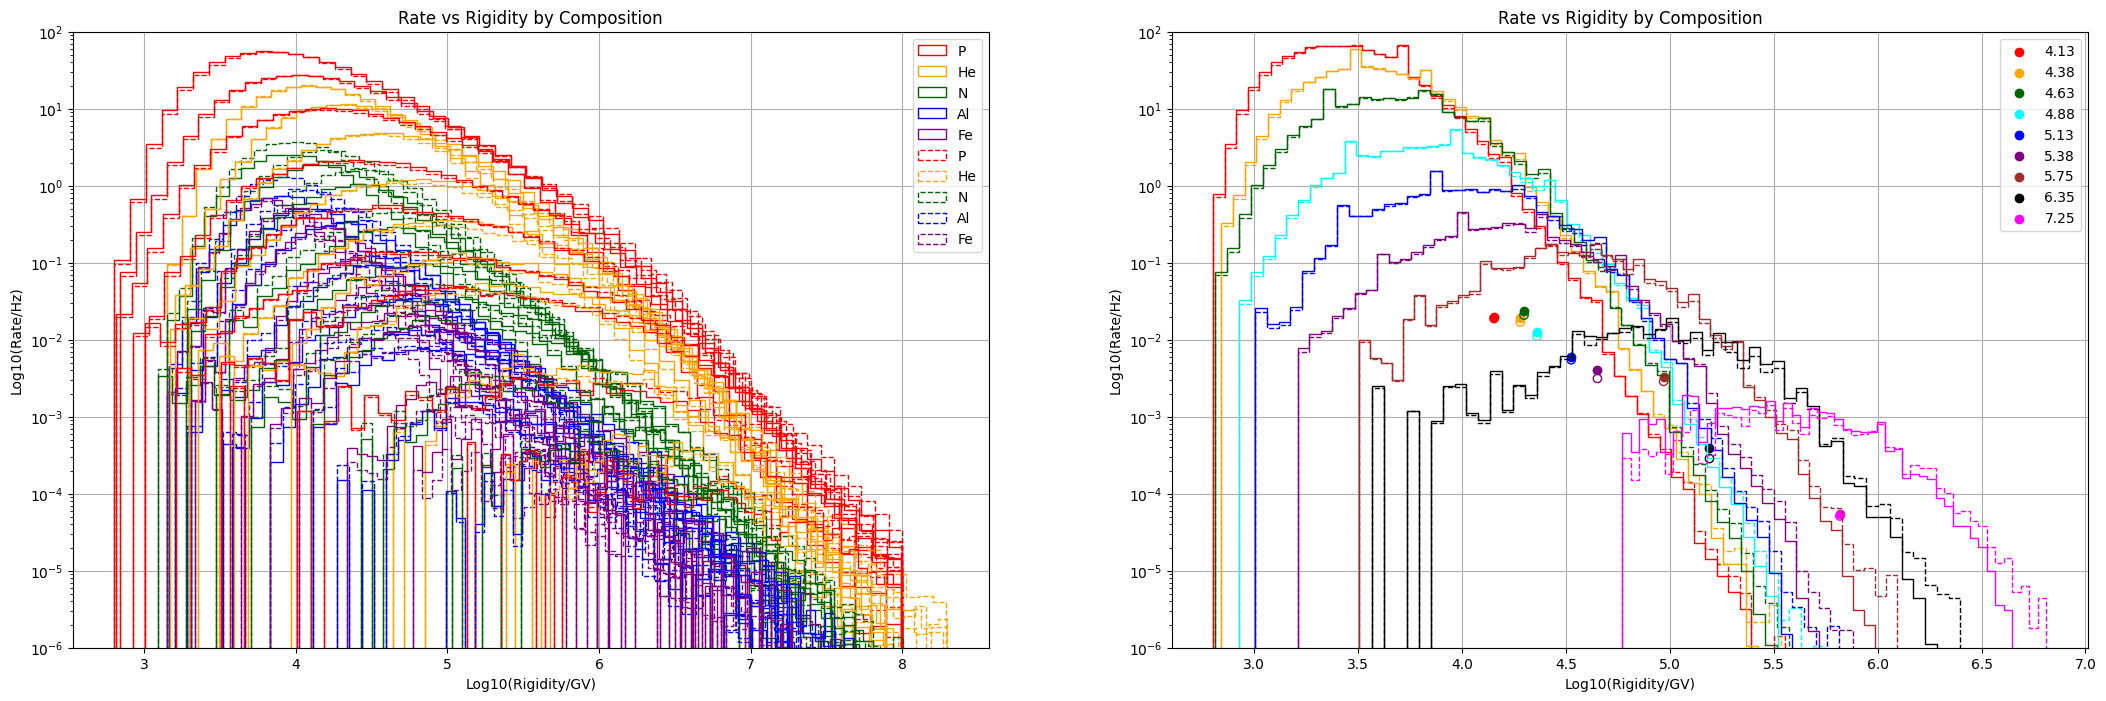

In [12]:
# Test cell to create rate vs rigidity composition graph
#bins=np.linspace(2.5, 7, 101)
bins=50
fig, axs = plt.subplots(figsize = (13 * ncols, 8), ncols=2)
medArrH = []
medArrG = []
for i in BINS:
    # Histograms for Gaisser H4a composition model
    # Need to use numpy histogram function to calculate histogram, then add together (and standardize bins)
    
    [pH_i, binph_i, pp_i] = axs[0].hist(np.log10(d['mc_energy'][np.logical_and(BINS[i],pcut, qual_cut)]/1), bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[i],pcut)], color = 'red',histtype = 'step', label ='P' if i == '4.125' else '', density=False)
    [HeH_i, binhh_i, ph_i] = axs[0].hist(np.log10(d['mc_energy'][np.logical_and(BINS[i],Hecut, qual_cut)]/2), bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[i],Hecut)], color = 'orange',histtype = 'step', label ='He' if i == '4.125' else '', density=False)
    [NH_i, binnh_i, pn_i] = axs[0].hist(np.log10(d['mc_energy'][np.logical_and(BINS[i],Ncut, qual_cut)]/7), bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[i],Ncut)], color = 'darkgreen',histtype = 'step', label ='N' if i == '4.125' else '', density=False)
    [AlH_i, binah_i, pa_i] = axs[0].hist(np.log10(d['mc_energy'][np.logical_and(BINS[i],Alcut, qual_cut)]/13), bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[i],Alcut)], color = 'blue',histtype = 'step', label ='Al' if i == '4.125' else '', density=False)
    [FeH_i, binfh_i, pf_i] = axs[0].hist(np.log10(d['mc_energy'][np.logical_and(BINS[i],Fecut, qual_cut)]/26), bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[i],Fecut)], color = 'purple',histtype = 'step', label ='Fe' if i == '4.125' else '', density=False)

    # Histograms for Global Spline Fit composition model
    [pG_i, binpg_i, ppg_i] = axs[0].hist(np.log10(d['mc_energy'][np.logical_and(BINS[i],pcut, qual_cut)]/1), bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[i],pcut)], color = 'red',histtype = 'step', label ='P' if i == '4.125' else '', density=False, linestyle='--')
    [HeG_i, binhg_i, phg_i] =axs[0].hist(np.log10(d['mc_energy'][np.logical_and(BINS[i],Hecut, qual_cut)]/2), bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[i],Hecut)], color = 'orange',histtype = 'step', label ='He' if i == '4.125' else '', density=False, linestyle='--')
    [NG_i, binng_i, png_i] = axs[0].hist(np.log10(d['mc_energy'][np.logical_and(BINS[i],Ncut, qual_cut)]/7), bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[i],Ncut)], color = 'darkgreen',histtype = 'step', label ='N' if i == '4.125' else '', density=False, linestyle='--')
    [AlG_i, binag_i, pag_i] = axs[0].hist(np.log10(d['mc_energy'][np.logical_and(BINS[i],Alcut, qual_cut)]/13), bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[i],Alcut)], color = 'blue',histtype = 'step', label ='Al' if i == '4.125' else '', density=False, linestyle='--')
    [FeG_i, binfg_i, pfg_i] = axs[0].hist(np.log10(d['mc_energy'][np.logical_and(BINS[i],Fecut, qual_cut)]/26), bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[i],Fecut)], color = 'purple',histtype = 'step', label ='Fe' if i == '4.125' else '', density=False, linestyle='--')

    # Median bins for Gaisser H4a model
    mbinprh_i = (binph_i[:1]+binph_i[:-1])/2
    mbinhrh_i = (binhh_i[:1]+binhh_i[:-1])/2
    mbinnrh_i = (binnh_i[:1]+binnh_i[:-1])/2
    mbinarh_i = (binah_i[:1]+binah_i[:-1])/2
    mbinfrh_i = (binfh_i[:1]+binfh_i[:-1])/2
    # Median bins for Global Spline Fit model
    mbinprg_i = (binpg_i[:1]+binpg_i[:-1])/2
    mbinhrg_i = (binhg_i[:1]+binhg_i[:-1])/2
    mbinnrg_i = (binng_i[:1]+binng_i[:-1])/2
    mbinarg_i = (binag_i[:1]+binag_i[:-1])/2
    mbinfrg_i = (binfg_i[:1]+binfg_i[:-1])/2

    # Bins and Weights for Gaisser H4a
    medbin_i = np.append((np.append((np.append(mbinprh_i, mbinhrh_i)), (np.append(mbinnrh_i, mbinarh_i)))),mbinfrh_i)
    medwt_i = np.append((np.append(np.append(pH_i, HeH_i), np.append(NH_i, AlH_i))), FeH_i)

    # Bins and Weights for Global Spline Fit
    medbing_i = np.append((np.append((np.append(mbinprg_i, mbinhrg_i)), (np.append(mbinnrg_i, mbinarg_i)))),mbinfrg_i)
    medwtg_i = np.append((np.append(np.append(pG_i, HeG_i), np.append(NG_i, AlG_i))), FeG_i)

    # Median Bin histogram for Gaisser H4a
    axs[1].hist(medbin_i, weights=medwt_i, bins=bins, log=True, histtype='step', density=False, color=BINC[i])

    # Median Bin histogram for Global Spline Fit
    axs[1].hist(medbing_i, weights=medwtg_i, bins=bins, log=True, histtype='step', density=False, color=BINC[i], linestyle='--')
    
    axs[1].scatter(np.median(medbin_i), np.median(medwt_i), color=BINC[i], label=BINL[i])
    axs[1].scatter(np.median(medbing_i), np.median(medwtg_i), color=BINC[i], facecolor='none')

    medArrH.append(np.median(medbin_i)-3)
    medArrG.append(np.median(medbing_i)-3)

    for k in range(0,2):
        axs[k].set_xlabel('Log10(Rigidity/GV)')
        axs[k].set_ylabel('Log10(Rate/Hz)')
        axs[k].set_title('Rate vs Rigidity by Composition')
        axs[k].grid()
        axs[k].legend()
        axs[k].set_ylim(.000001, 100)
    
    #print('median LogR GH4' + '(' + i + ' logE bin): ' + str(round(np.median(medbin_i-3),2)) + ' TV')
    #print('median LogR GSF' + '(' + i + ' logE bin): ' + str(round(np.median(medbing_i-3),2)) + ' TV')

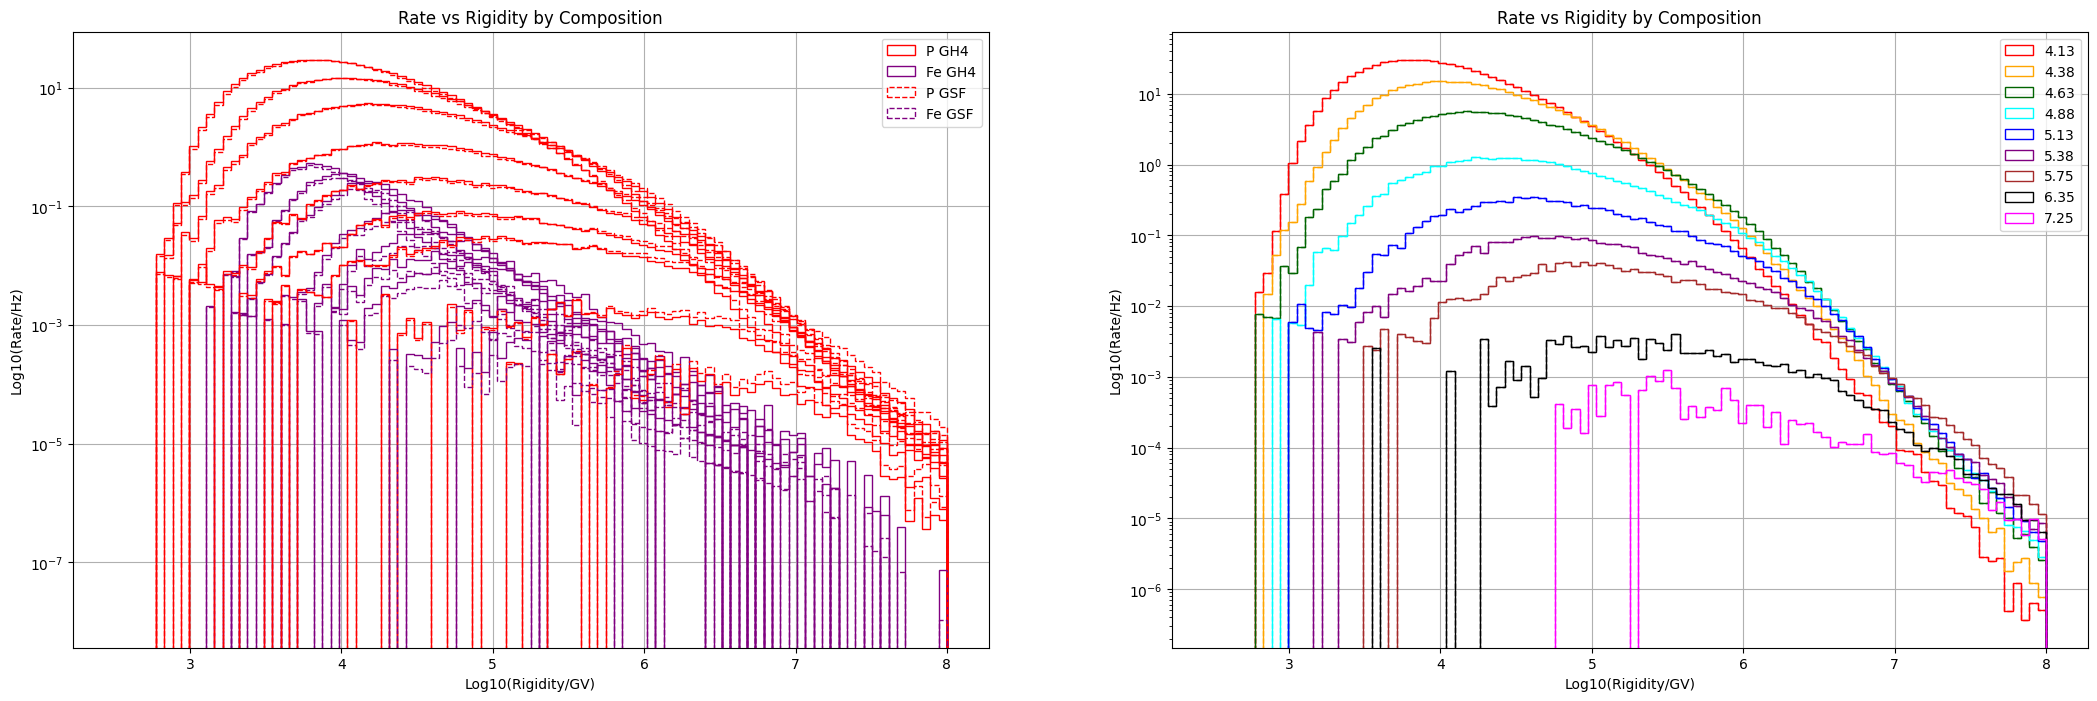

In [13]:
fig, axs = plt.subplots(figsize = (13 * ncols, 8), ncols=2)
bins=np.linspace(2.5, 8, 101)
for i in BINS:
    # Histograms for Gaisser H4a composition model
    [pH_i, binph_i, pp_i] = axs[0].hist(np.log10(d['mc_energy'][np.logical_and(BINS[i],pcut, qual_cut)]/1), bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[i],pcut)], color = 'red',histtype = 'step', label ='P GH4' if i == '4.125' else '', density=False)
    [FeH_i, binfh_i, pf_i] = axs[0].hist(np.log10(d['mc_energy'][np.logical_and(BINS[i],Fecut, qual_cut)]/26), bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[i],Fecut)], color = 'purple',histtype = 'step', label ='Fe GH4' if i == '4.125' else '', density=False)
    #totH_i = axs[0].hist((binph_i + binfh_i), bins = 10, color='black', label='total GH4' if i=='4.125' else '', density=False, histtype='step')

    [pG_i, binpg_i, ppg_i] = axs[0].hist(np.log10(d['mc_energy'][np.logical_and(BINS[i],pcut, qual_cut)]/1), bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[i],pcut)], color = 'red',histtype = 'step', label ='P GSF' if i == '4.125' else '', density=False, linestyle='--')
    [FeG_i, binfg_i, pfg_i] = axs[0].hist(np.log10(d['mc_energy'][np.logical_and(BINS[i],Fecut, qual_cut)]/26), bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[i],Fecut)], color = 'purple',histtype = 'step', label ='Fe GSF' if i == '4.125' else '', density=False, linestyle='--')

    mbinprh_i = (binph_i[1:]+binph_i[:-1])/2
    mbinfrh_i = (binfh_i[1:]+binfh_i[:-1])/2
    medbin_i = np.append(mbinprh_i, mbinfrh_i)
    medwt_i = np.append(pH_i, FeH_i)

    mbinprg_i = (binpg_i[1:]+binpg_i[:-1])/2
    mbinfrg_i = (binfg_i[1:]+binfg_i[:-1])/2
    medbing_i = np.append(mbinprg_i, mbinfrg_i)
    medwtg_i = np.append(pG_i, FeG_i)
        
    axs[1].hist(medbin_i, weights=medwt_i, bins=bins, log=True, histtype='step', density=False, color=BINC[i], label=BINL[i])
    axs[1].hist(medbin_i, weights=medwt_i, bins=bins, log=True, histtype='step', density=False, color=BINC[i], linestyle='--')

    for k in range(0,2):
        axs[k].set_xlabel('Log10(Rigidity/GV)')
        axs[k].set_ylabel('Log10(Rate/Hz)')
        axs[k].set_title('Rate vs Rigidity by Composition')
        axs[k].grid()
        axs[k].legend()

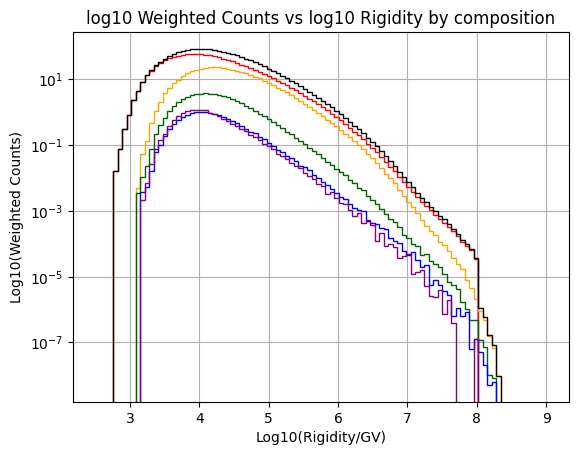

In [14]:
bins=np.linspace(2.5, 9, 101)
recon = d['mc_energy']

[pH, bph, pph] = plt.hist(np.log10(recon[np.logical_and(bin_cut, pcut, qual_cut)]/1), bins = bins, weights=d['GaisserH4a'][np.logical_and(bin_cut,pcut)], log=True, color='red', histtype='step',density=False)
[HeH, bhh, phh] = plt.hist(np.log10(recon[np.logical_and(bin_cut, Hecut, qual_cut)]/2), bins = bins, weights=d['GaisserH4a'][np.logical_and(bin_cut,Hecut)], log=True, color='orange', histtype='step',density=False)
[NH, bnh, pnh] = plt.hist(np.log10(recon[np.logical_and(bin_cut, Ncut, qual_cut)]/7), bins = bins, weights=d['GaisserH4a'][np.logical_and(bin_cut,Ncut)], log=True, color='darkgreen', histtype='step',density=False)
[AlH, bah, pah] = plt.hist(np.log10(recon[np.logical_and(bin_cut, Alcut, qual_cut)]/13), bins = bins, weights=d['GaisserH4a'][np.logical_and(bin_cut,Alcut)], log=True, color='blue', histtype='step',density=False)
[FeH, bfh, pfh] = plt.hist(np.log10(recon[np.logical_and(bin_cut, Fecut, qual_cut)]/26), bins = bins, weights=d['GaisserH4a'][np.logical_and(bin_cut,Fecut)], log=True, color='purple', histtype='step',density=False)

mbph = (bph[1:]+bph[:-1])/2
mbhh = (bhh[1:]+bhh[:-1])/2
mbnh = (bnh[1:]+bnh[:-1])/2
mbah = (bah[1:]+bah[:-1])/2
mbfh = (bfh[1:]+bfh[:-1])/2

totH = np.append(np.append(np.append(mbph, mbhh), np.append(mbnh, mbah)), mbfh)
wH = np.append(np.append(np.append(pH, HeH), np.append(AlH, NH)), FeH)

plt.hist(totH, weights=wH, color='black', histtype='step', bins=bins)

plt.xlabel('Log10(Rigidity/GV)')
plt.ylabel('Log10(Weighted Counts)')
plt.title('log10 Weighted Counts vs log10 Rigidity by composition')
plt.grid()

In [15]:
MRAR=[]
MNAR =[]
for i in BINS:
    RARR = []
    NAR=[]
    for comp in CCUT:
        acut = BINS[i] * CCUT[comp] * qual_cut
        
        ICR_comp = np.log10(d['mc_energy'][acut]/Z[comp])
        #plt.hist(ICR_comp, weights=d['GaisserH4a'][acut], histtype='step', log=True, color=BINC[i]) 
        RARR.append(ICR_comp)
    ncut = BINS[i] * CCUT[comp] * qual_cut
    NR = np.log10(d['mc_energy'][ncut]/7)
    NAR.append(NR)
    MRAR.append(weighted_quantiles(ICR_comp, d['GaisserH4a'][acut])-3) # -3 to scale to TeV
    MNAR.append(weighted_quantiles(NR, d['GaisserH4a'][ncut])-3) 

print(MRAR)
#print(MNAR)

[0.8589835502975145, 1.0349871936314825, 1.206186699406821, 1.4317906569211525, 1.601279073351936, 1.723730689684916, 1.9014938701783501, 2.1375876498620547, 2.4342265288501705]


In [16]:
# Calculate IceCube rigidity - mc_energy is not in log10
ic_rigidity = np.log10(d['mc_energy']) - 3
for comp, comp_cut in IC_COMPS.items():
    ic_rigidity[comp_cut] -= np.log10(Z[comp])

# Calculate median rigidity - note BINS are the IceCube BINS and comes from reco_energy.ipynb
ic_median_rigidity = []
for cut in BINS.values():
    combined_cut = cut * qual_cut
    
    ic_median_rigidity.append(weighted_quantiles(ic_rigidity[combined_cut], d['GlobalSplineFit5Comp'][combined_cut]))

print(ic_median_rigidity)

[0.8345067124591854, 1.0019296742561477, 1.1582973836418617, 1.3709255915353469, 1.5275164426038297, 1.6223793335567678, 1.7907727338114603, 2.036491083871888, 2.3900424131251867]


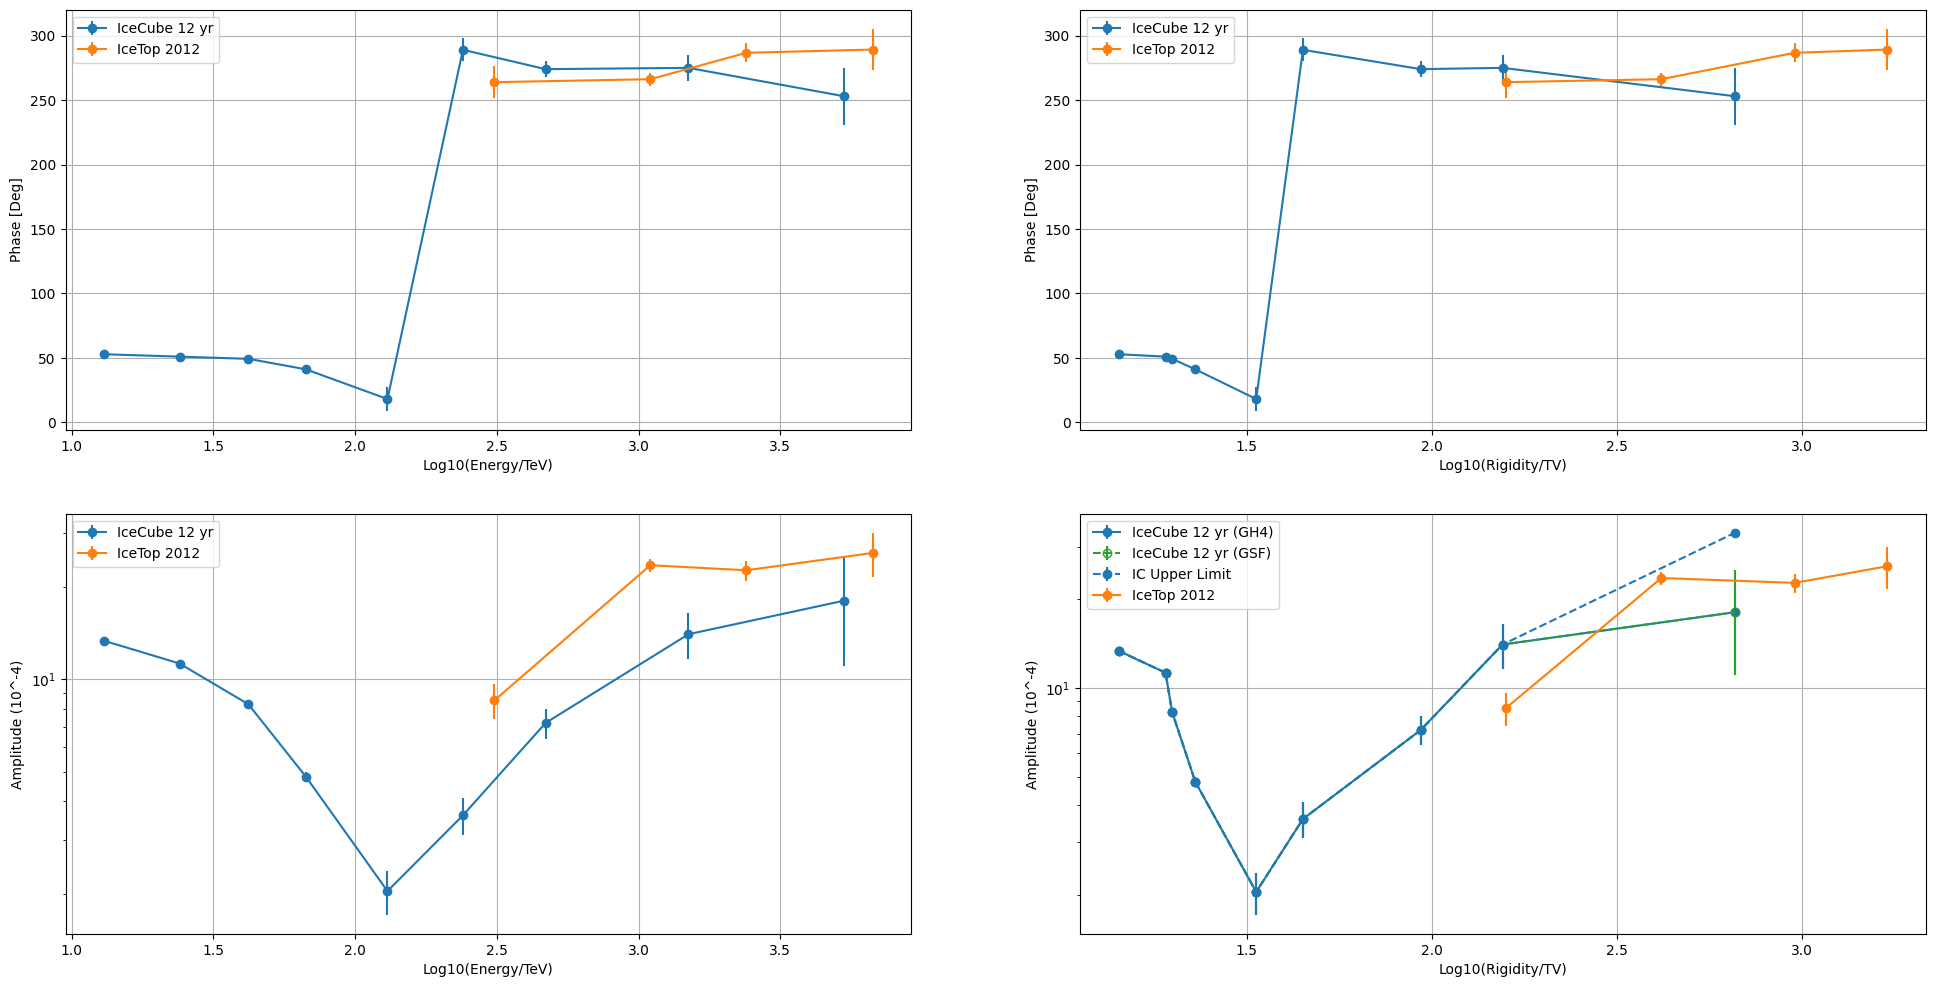

In [17]:
# Cell for computing the dipole phase/amplitude as a function for rigidity
# data provided by paolo, alex, and this notebook
fig, axs = plt.subplots(figsize = (13 * ncols, 8), ncols=2, nrows=2)

# IceCube energy plot arrays plus error bars and proposed upper bound
# icr is IceCube rigidity calculated in this notebook
ice = np.log10([13, 24, 42, 67, 130, 240, 470, 1500, 5300])
ica = [13.33, 11.24, 8.28, 4.81, 2.04, 3.6, 7.2, 14.0, 18.0]
icu = [13.33, 11.24, 8.28, 4.81, 2.04, 3.6, 7.2, 14.0, 33.4]
icf = [52.76, 50.91, 49.2, 41.05, 18.0, 289.0, 274.0, 275.0, 253.0]
icrh = medArrH
icrg = medArrG

# IceTop energy plot arrays plus error bars
# itr is IceTop rigidity provided by alex
ite = np.log10([310, 1100, 2400, 6700])
ita = [4.9*1.74, 13.5*1.74, 13.0*1.74, 14.8*1.74]
itf = [263.9, 266.2, 286.7, 289.2]
itr = [2.2,2.62,2.98,3.23]

# Rigidity plot arrays with proposed upper bound and error bars
icar = [0.05, 0.05, 0.09, 0.17, 0.33, 0.5, 0.8, 2.4, 7]
icarus = [0.05, 0.05, 0.09, 0.17, 0.33, 0.5, 0.8, 2.4, 0]
icfr = [0.20, 0.28, 0.6, 2.0, 9, 9, 6, 10, 22]
itar= [1.1, 1.2, 1.7, 4.2]
itfr= [12.6, 5.0, 7.4, 16.1]

# Produce line plots with errorbars for phase and amplitude dipoles
axs[0,0].errorbar(ice, icf, icfr, marker='o', label='IceCube 12 yr')
axs[0,0].errorbar(ite, itf, itfr, marker='o', label='IceTop 2012')
axs[0,1].errorbar(icrh, icf, icfr, marker='o', label='IceCube 12 yr')
axs[0,1].errorbar(itr, itf, itfr, marker='o', label='IceTop 2012')

axs[1,0].errorbar(ice, ica, icar, marker='o', label='IceCube 12 yr')
axs[1,0].errorbar(ite, ita, itar, marker='o', label='IceTop 2012')

axs[1,1].errorbar(icrh, ica, icar, marker='o', color='C0', label='IceCube 12 yr (GH4)')
axs[1,1].errorbar(icrg, ica, icar, marker='o', mfc='none', color='C2', label='IceCube 12 yr (GSF)', linestyle='--')
axs[1,1].errorbar(icrh, icu, icarus, marker='o', color='C0', linestyle='--', label='IC Upper Limit')
axs[1,1].errorbar(itr, ita, itar, marker='o',color='C1', label = 'IceTop 2012')

# for loops to set labels, grids, and legends for each grid
for i in range(0,2):
    axs[i,0].set_xlabel('Log10(Energy/TeV)')
    axs[i,1].set_xlabel('Log10(Rigidity/TV)')
    axs[0,i].set_ylabel('Phase [Deg]')
    axs[1,i].set_ylabel('Amplitude (10^-4)')
    axs[1,i].set_yscale('log')
    for j in range(0,2):
        axs[i,j].grid()
        axs[i,j].legend()
        
fig.set_size_inches(24,12)

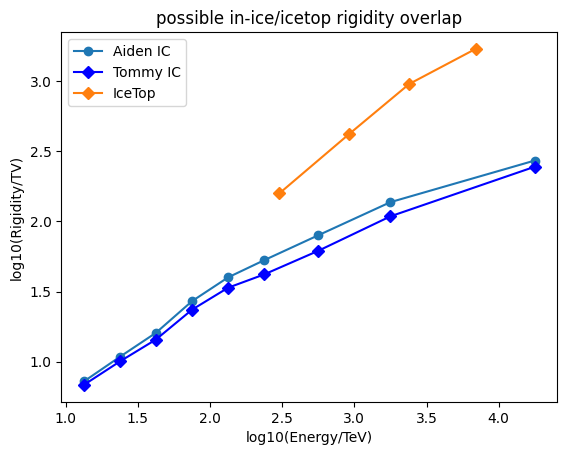

In [18]:
# Little cell that creates a line plot to compare in-ice and icetop median rigidity
ic_median_rigidity
MRAR
x=[float(key)-3 for key in BINS.keys()]
ITmedArr=[2.2,2.62,2.98,3.23]
ITX=[2.48,2.96,3.38,3.84]
plt.plot(x, MRAR, color='C0', label='Aiden IC', marker='o')
plt.plot(x, ic_median_rigidity, color='blue', label='Tommy IC', marker='D')
plt.plot(ITX, ITmedArr, color='C1', label='IceTop', marker='D')
plt.xlabel('log10(Energy/TeV)')
plt.ylabel('log10(Rigidity/TV)')
plt.title('possible in-ice/icetop rigidity overlap')
plt.legend()